In [1]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch_box

from MGTomo.gridop import P,R, RBox, PBox

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
N = 255
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [3]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = mgproj.TomoTorch(model.proj_factory(fine_dim))
b = A(x_torch)

In [4]:
fh = lambda x: fcts.kl_distance(x, A, b)

In [42]:
def GD1(x, f):
    x1 = fcts.BSMART(f, x, 1)
    val = fcts.kl_distance_no_matrix(x1, x) - 0.3*1e-3 *f(x)

    return val

In [43]:
x0 = torch.rand(N, N, requires_grad = True)
GD1(x0, fh)

tensor(29670.0768, dtype=torch.float64, grad_fn=<SubBackward0>)

In [94]:
def AssB(x, f, tau):
    x1 = fcts.BSMART(f, x, 1)
    xtau = fcts.BSMART(f,x,tau)
    val = fcts.kl_distance_no_matrix(xtau, x) - tau *fcts.kl_distance_no_matrix(x1, x)

    return val.item()

In [91]:
z0 = torch.rand(N, N, requires_grad = True)
for i in range(100):
    val = fcts.BSMART(fh, z0, tau)
    x1 = fcts.BSMART(fh, z0, 1)
    z0 = val.clone().detach().requires_grad_(True)

    #assert AssB(z0, fh, tau) >= 0 

In [92]:
fh(z0)

tensor(283.7254, dtype=torch.float64, grad_fn=<AddBackward0>)

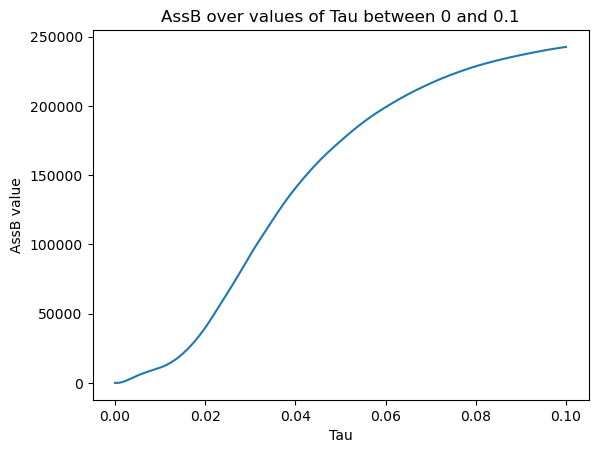

In [99]:
# Create a range of tau values between 0 and 1
tau_values = np.linspace(0, 0.1, 1000)

# Placeholder for the AssB values
AssB_values = []

# Calculate the AssB values for each tau
for tau in tau_values:
    AssB_values.append(AssB(z0, fh, tau))

# Plot the results
plt.plot(tau_values, AssB_values)
plt.xlabel('Tau')
plt.ylabel('AssB value')
plt.title('AssB over values of Tau between 0 and 0.1')
plt.show()

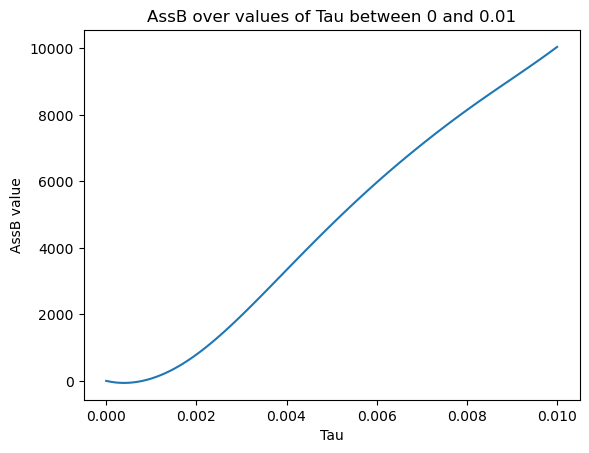

In [98]:
# Create a range of tau values between 0 and 1
tau_values = np.linspace(0, 0.01, 100)

# Placeholder for the AssB values
AssB_values = []

# Calculate the AssB values for each tau
for tau in tau_values:
    AssB_values.append(AssB(z0, fh, tau))

# Plot the results
plt.plot(tau_values, AssB_values)
plt.xlabel('Tau')
plt.ylabel('AssB value')
plt.title('AssB over values of Tau between 0 and 0.01')
plt.show()

In [ ]:


fcts.kl_distance_no_matrix(xtau, x0) - 1/54 * fcts.kl_distance_no_matrix(x1, x0)

In [88]:
AssB_values

[-56213.390625,
 -155.765625,
 -3.1640625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

norm of A is ca. 1/54 by computations done locally

In [55]:
tau = 1/5
x0 = torch.rand(N, N, requires_grad = True)
AssB(x0, fh, tau)

0.0

In [60]:
x1 = fcts.SMART(fh, x0, 1)
xtau = fcts.SMART(fh,x0,tau)

In [61]:
fcts.kl_distance_no_matrix(xtau, x0) -  fcts.kl_distance_no_matrix(x1, x0)

tensor(0., grad_fn=<SubBackward0>)

In [62]:
fcts.kl_distance_no_matrix(xtau, x1)

tensor(0., grad_fn=<AddBackward0>)

In [63]:
fx = fh(x0)
fx.backward(retain_graph = True)
x0grad = x0.grad

In [64]:
x0.grad

tensor([[187983.9844, 170792.3906, 167712.0625,  ..., 168395.7500,
         175055.2188, 189605.2969],
        [191701.3906, 190385.8594, 167864.1406,  ..., 167369.1875,
         193532.0469, 191047.2188],
        [166890.4844, 165605.4375, 142348.4531,  ..., 140392.5156,
         167320.7656, 164828.0156],
        ...,
        [169282.9375, 170136.8281, 139685.8125,  ..., 139188.0781,
         172366.6094, 169444.5000],
        [196190.9844, 196814.7031, 167154.7031,  ..., 167047.7344,
         199463.1094, 196795.8125],
        [191940.6875, 177055.0312, 166951.0156,  ..., 164638.1719,
         175450.9844, 191516.7812]])

In [81]:
x0 * myexp(-x0.grad)

tensor([[1.9077e-22, 1.3888e-22, 1.2693e-22,  ..., 8.3557e-23, 1.2585e-22,
         1.6613e-24],
        [3.7282e-23, 1.3523e-22, 2.3468e-23,  ..., 5.4755e-23, 1.8467e-22,
         1.1504e-22],
        [1.3409e-23, 4.6196e-23, 5.2529e-24,  ..., 2.6046e-23, 1.8054e-22,
         9.7476e-23],
        ...,
        [1.5608e-23, 1.9183e-22, 7.7500e-23,  ..., 1.5779e-22, 7.6147e-23,
         1.7113e-22],
        [1.7796e-22, 1.9252e-22, 4.2294e-23,  ..., 7.1608e-23, 5.8049e-23,
         1.8926e-22],
        [6.0833e-23, 1.7180e-22, 1.8092e-22,  ..., 1.5018e-22, 1.9112e-23,
         9.6654e-24]], grad_fn=<MulBackward0>)

In [82]:
val = x0 * myexp(-tau * x0.grad)

In [4]:
N = 7
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [20]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 20, 'level_decrease' : 1})
fine_dim = model.dim
A = mgproj.TomoTorch(model.proj_factory(fine_dim))
b = A(x_torch)

In [21]:
A.shape

(140, 49)

In [22]:
x0 = torch.rand(N, N, requires_grad = True)

In [23]:
def AssB(x, f, tau):
    x1 = fcts.BSMART(f, x, 1)
    xtau = fcts.BSMART(f,x,tau)
    val = fcts.kl_distance_no_matrix(xtau, x) -  fcts.kl_distance_no_matrix(x1, x)

    return val.item()

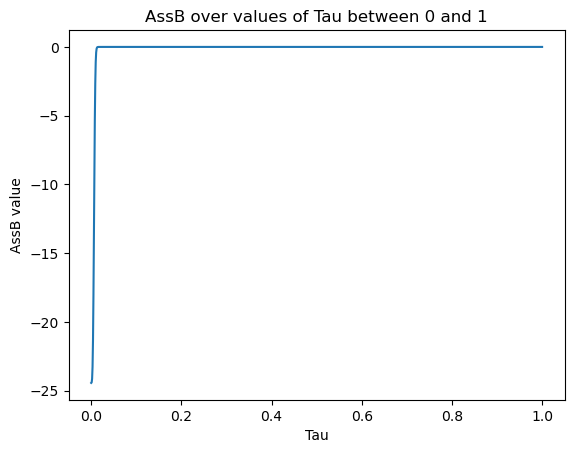

In [24]:
# Create a range of tau values between 0 and 1
tau_values = np.linspace(0, 1, 1000)

# Placeholder for the AssB values
AssB_values = []

# Calculate the AssB values for each tau
for tau in tau_values:
    AssB_values.append(AssB(x0, fh, tau))

# Plot the results
plt.plot(tau_values, AssB_values)
plt.xlabel('Tau')
plt.ylabel('AssB value')
plt.title('AssB over values of Tau between 0 and 1')
plt.show()

In [25]:
AssB_values

[-24.43575096130371,
 -24.402694702148438,
 -24.13758087158203,
 -23.257164001464844,
 -21.303373336791992,
 -18.031923294067383,
 -13.737762451171875,
 -9.24416732788086,
 -5.405506134033203,
 -2.6762866973876953,
 -1.1117401123046875,
 -0.3985633850097656,
 -0.1284770965576172,
 -0.03873634338378906,
 -0.011331558227539062,
 -0.0033111572265625,
 -0.0009765625,
 -0.0002918243408203125,
 -8.392333984375e-05,
 -2.288818359375e-05,
 -7.62939453125e-06,
 -1.9073486328125e-06,
 -1.9073486328125e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [32]:
x1 = fcts.SMART(fh, x0, 1)
xtau = fcts.SMART(fh,x0,0.5)

In [33]:
fcts.kl_distance_no_matrix(xtau, x0) - fcts.kl_distance_no_matrix(x1, x0)

tensor(0., grad_fn=<SubBackward0>)

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)